# 有限井戸型ポテンシャルの解法と数値計算

参考にしたサイトなど
<ul>
<li><a href="http://www.th.phys.titech.ac.jp/~muto/lectures/QMI10/QMI10_chap05.pdf" style="text-decoration:none;">第5章 井戸型ポテンシャルでの束縛状態(QMI10_chap05.pdf) - 量子力学第一（平成２２年度）| 武藤研究室（東工大）</a></li>
</ul>


## 一次元無限井戸型ポテンシャルの解

$$V(x) = \begin{cases}V_0&x< -b/2, b/2 < x\\0&\text{other}\end{cases}$$

のポテンシャル下での時間に依存しないSchrödinger方程式

$$\hat{H} ψ = \left[\vphantom{\frac{\hbar}{2m}}\right. \underbrace{-\frac{\hbar}{2m}\frac{d}{dx}}_{\hat{H}_0} + V(x) \left.\vphantom{\frac{\hbar}{2m}}\right] ψ = Eψ$$

を解くと，

$$ψ(x) = \sqrt{\frac{2}{b}}\sin{\frac{nπ}{b}\left(x + \frac{b}{2}\right)}, n = 1, 2, ...$$

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams

"""initial settings"""
rcParams["figure.dpi"] = 150
rcParams["font.sans-serif"] = "Inter"

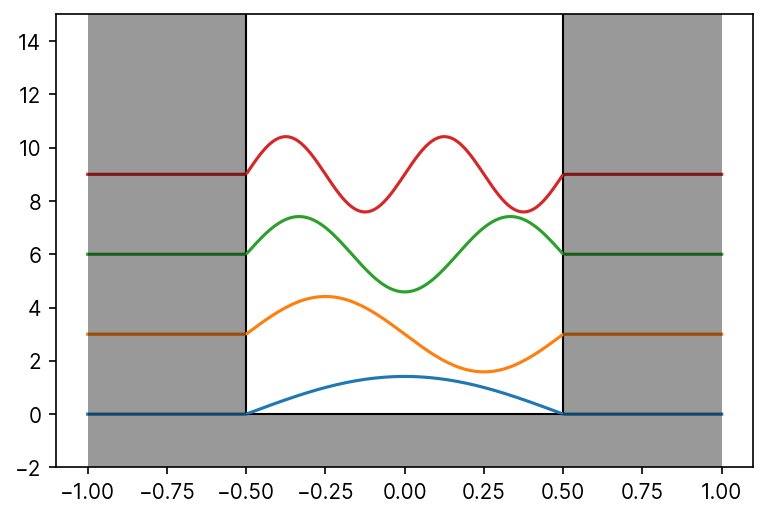

In [2]:
from copy import copy
from typing import Tuple

import matplotlib
import numpy as np
from matplotlib import colors, patches
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb, to_rgba
from numpy import cos, pi, sin, sqrt

"""
width of well
"""
b: float = 1.0


def get_eigenfunc_value(main_qnum: int, x: float) -> float:
    return sqrt(2 / b) * sin((main_qnum * pi) * (x + b / 2) / b) if -b / 2 <= x <= b / 2 else 0


def get_well(
    height: float, depth: float, xlim: Tuple[float, float], width: float
) -> Tuple[patches.Polygon, patches.PathPatch]:
    _x_min, _x_max = xlim
    _p = patches.Polygon(
        xy=[
            (-width / 2, -depth),
            (width / 2, -depth),
            (width / 2, height),
            (_x_max, height),
            (_x_max, 0),
            (_x_min, 0),
            (_x_min, height),
            (-width / 2, height),
            (-width / 2, -depth),
        ],
        fc=to_rgba("black", 0.4),
        zorder=10,
    )
    _l = patches.Polygon(
        xy=[(_x_max, height), (_x_max, 0), (_x_min, 0), (_x_min, height),],
        ec="black",
        fill=False,
    )
    return _p, _l


max_ylim: float = 10
x_range: float = 1.0
diff: float = 3.0
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.subplots()

x = np.linspace(-x_range, x_range, 200)

ax.set_ylim((-2, 15))
for main_quantum_num in range(1, 5):
    ax.plot(
        x, [get_eigenfunc_value(main_quantum_num, i) + diff * main_quantum_num - diff for i in x],
    )

r_height, r_depth = 40, 2

poly, path = get_well(40, 2, (-b / 2, b / 2), 2 * x_range)
ax.add_patch(poly)
ax.add_patch(path)

## 無限井戸の数値計算

続いて，数値計算で上の結果が再現するか確認。

方法としては，“境界値問題を行列の固有値問に帰着させ，その行列方程式を解くことで常微分方程式の解(固有関数)および固有値を決定”（[[Pythonによる科学・技術計算]行列形式による常微分方程式の境界値問題の解法，数値計算 - Qiita](https://qiita.com/sci_Haru/items/2d238fcadbe7990239df) より）する方法をとった。実装は[Pythonで覗く, こわくない量子力学1 : 無限井戸型ポテンシャル - Qiita](https://qiita.com/jabberwocky0139/items/136f34add9e522f2d3ff)を参考にした。


- ポテンシャルV(x)が与えられたとき，

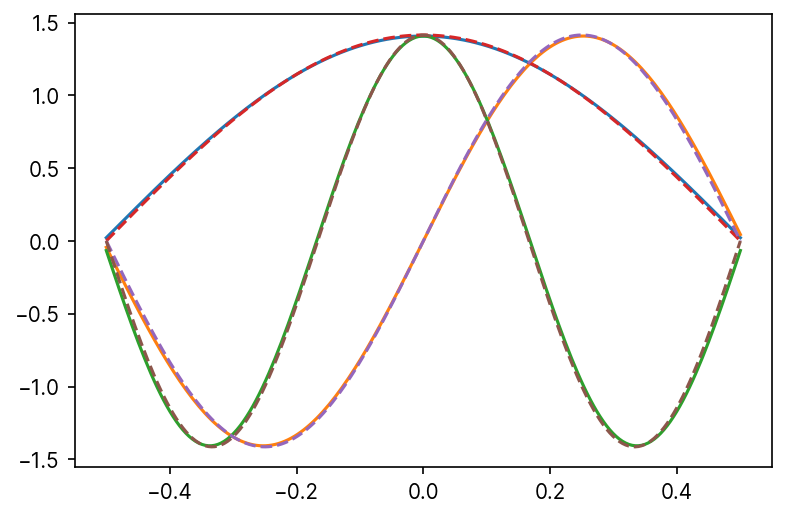

In [3]:
# [Pythonで覗く, こわくない量子力学1 : 無限井戸型ポテンシャル](https://qiita.com/jabberwocky0139/items/136f34add9e522f2d3ff) より一部改変
import matplotlib.pyplot as plt
import numpy as np
from numpy import eye  # numpy.eye(N): N*Nの単位行列
from scipy.integrate import simps

## set parameters
L, N = 1, 200
x, dx = np.linspace(-L / 2, L / 2, N), L / N

## set kinetic matrix
K_sub = np.vstack((eye(N)[1:], np.array([0] * N)))
# ↑ numpy.vstack: 行列を下に結合して拡張する
# | K[1:]（K[1:, :]の省略）で行のindex=1以降を取り出す（スライス：[start:stop:step]）
# | np.array([0] * N) => [0 0 0 ... 0 ] (N次元ゼロベクトル)
# -> 単位行列を一個ずらしたやつ！！が得られる。
# | 0 1 0 0 ...|
# | 0 0 1 0 ...|
# | 0 0 0 1 ...|
# | 0 0 0 0 ...|
# | ...

K = dx ** -2 * (2 * eye(N) - K_sub - K_sub.T)
# | -2  1  0  0 ...|
# |  1 -2  1  0 ...|
# |  0  1 -2  1 ...|
# |  0  0  1 -2 ...|
# | ...


V = np.diag([0] * N)


## set Hamiltonian
H = (K + V) / 2

## solve igenvalue equation
w, v = np.linalg.eigh(H)

## plot
plt.plot(x, v.T[0] / simps(v.T[0] ** 2, x) ** 0.5, label="ground state")
plt.plot(x, v.T[1] / simps(v.T[1] ** 2, x) ** 0.5, label="1st excited state")
plt.plot(x, v.T[2] / simps(v.T[2] ** 2, x) ** 0.5, label="2nd excited state")
plt.plot(
    x, 2 * np.sin(np.pi * (x + L / 2) / L) / np.sqrt(2 * L), "--", label="analytic(ground)",
)
plt.plot(
    x, -2 * np.sin(2 * np.pi * (x + L / 2) / L) / np.sqrt(2 * L), "--", label="analytic(1st)",
)
plt.plot(
    x, -2 * np.sin(3 * np.pi * (x + L / 2) / L) / np.sqrt(2 * L), "--", label="analytic(2nd)",
)
plt.show()

## 有限井戸

上ではポテンシャルを&minus;L/2≤x≤L/2でゼロとしていたが，ここを中央で0，その外側で正の値としてやると有限井戸が再現できる。ということで適当に実装してみる（精度とか知らんけど）。

ここでは，位置座標を与えるとポテンシャルを返す関数 `get_V(x)` を以下のように定義し，
```python
def get_V(x):
    return 0 if -L/2 <= x <= L/2 else 5000
```
ポテンシャル `V` を `V = np.diag([get_V(x_i) for x_i in x])` として与えた。また，計算するxの範囲を&minus;LからLまで広げた。

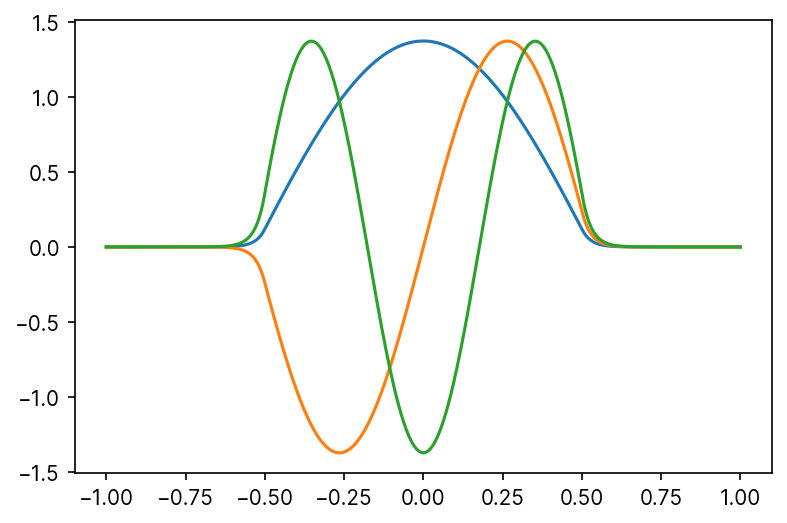

In [4]:
# [Pythonで覗く, こわくない量子力学1 : 無限井戸型ポテンシャル](https://qiita.com/jabberwocky0139/items/136f34add9e522f2d3ff)有限井戸用に改変
import matplotlib.pyplot as plt
import numpy as np
from numpy import eye  # numpy.eye(N): N*Nの単位行列
from scipy.integrate import simps

## set parameters
L, N = 1, 500
# x, dx = np.linspace(-L/2, L/2, N), L / N
x, dx = np.linspace(-L, L, N), L / N

## set kinetic matrix
K_sub = np.vstack((eye(N)[1:], np.array([0] * N)))
# ↑ numpy.vstack: 行列を下に結合して拡張する
# | K[1:]（K[1:, :]の省略）で行のindex=1以降を取り出す（スライス：[start:stop:step]）
# | np.array([0] * N) => [0 0 0 ... 0 ] (N次元ゼロベクトル)
# -> 単位行列を一個ずらしたやつ！！が得られる。
# | 0 1 0 0 ...|
# | 0 0 1 0 ...|
# | 0 0 0 1 ...|
# | 0 0 0 0 ...|
# | ...

K = dx ** -2 * (2 * eye(N) - K_sub - K_sub.T)  # =>

# V = np.diag([0] * N)
def get_V(x):
    return 0 if -L / 2 <= x <= L / 2 else 5000


V = np.diag([get_V(x_i) for x_i in x])


## set Hamiltonian
H = (K + V) / 2

## solve igenvalue equation
w, v = np.linalg.eigh(H)

## plot
plt.plot(x, v.T[0] / simps(v.T[0] ** 2, x) ** 0.5, label="ground state")
plt.plot(x, v.T[1] / simps(v.T[1] ** 2, x) ** 0.5, label="1st excited state")
plt.plot(x, v.T[2] / simps(v.T[2] ** 2, x) ** 0.5, label="2nd excited state")
# plt.plot(x, 2 * np.sin(np.pi * (x+L/2) /L) / np.sqrt(2 * L), '--', label="analytic(ground)")
# plt.plot(x, -2 * np.sin(2 * np.pi * (x+L/2) /L) / np.sqrt(2 * L), '--', label="analytic(1st)")
# plt.plot(x, -2 * np.sin(3 * np.pi * (x+L/2) /L) / np.sqrt(2 * L), '--', label="analytic(2nd)")
plt.show()

↑ということでなんとなく染み出しが再現できている気がします